In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

rng = np.random.default_rng()

In [2]:
def generar_particiones(filename, n, p_test):
    ds = np.genfromtxt(filename, delimiter=',')
    n_test = int(ds.shape[0] * p_test)
    n_train = ds.shape[0] - n_test
    M_test = np.zeros((n,n_test),dtype = int)
    M_train = np.zeros((n, n_train),dtype = int)

    for i in range(n):
        idx = np.random.choice(range(ds.shape[0]),ds.shape[0],replace = False)
        idx_test = idx[0:n_test]
        idx_train = idx[n_test:ds.shape[0]]
        M_test[i] = idx_test
        M_train[i] = idx_train
    
    return (ds, M_test, M_train)

def sigmoidea(x):
    return np.divide(2, (1 + np.exp(-1 * x))) - 1

class layer:
    def __init__(self, NNeurons, NInputs):
        # Almacenar la dimensión de entrada y cantidad de neuronas
        self.neurons_ = NNeurons
        self.inputs_ = NInputs

        # Inicializar la matriz de pesos de N x M con valores aleatorios
        # con una distribución normal centrada en 0 y norma < 0.5 aprox 
        # self.w = np.random.normal(loc = 0, scale = 0.15, size = (NNeurons, NInputs))
        self.w = rng.random((NNeurons, NInputs))
        
    def eval(self, x):
        # Comprobar que la dimension de la entrada es igual a la incializada 
        assert x.shape[0] == self.inputs_, \
            f"La entrada de dimensión {x.shape[0]} no coincide con la declarada {self.inputs_}"

        # Producto interno entre la entrada y los pesos
        y = np.dot(self.w, x)
        
        # No linealidad
        z = sigmoidea(y)
        return z

def MultiLayerPerceptron_init(neuronsPerLayer, NInputs):
    # La red estará representada como un arreglo de capas
    network_ = []
    
    # Auxiliar para definiar la cantidad de entradas de cada capa
    # La primera coincide con la entrada de la red
    NInputs_aux = NInputs

    # Para cada capa representada como el número de neuronas
    for layerNeurons in neuronsPerLayer:
        # Se crea una capa en base a la cantidad de salidas de la capa
        # anterior + 1 (el bias) y con el número de neuronas indicado
        network_.append(layer(layerNeurons, NInputs_aux + 1))
        
        # Adelantar la cantidad de entradas para la próxima capa
        NInputs_aux = layerNeurons
        
    return network_

def MultiLayerPerceptron_forward(network, input):
    # La salida de cada capa será acumulada en un arreglo
    # que es devuelto para luego utilizar en la etapa de train
    y = [input]
    
    for i in range(len(network)): # Para cada capa en la red
        # Agregar el bias a la entrada de la capa i (como primer componente)
        x_ = np.hstack((-1, y[i]))

        # Calcular la salida de la capa i
        y_ = network[i].eval(x_)
        
        # Agregar la salida al arreglo, que será la entrada de la siguiente
        y.append(y_)

    return y

def MultiLayerPerceptron_backward(network, y, yd):
    # Se calcula el error entre la salida de la red (último componente de y)
    # y la salida deseada (la dimensión será la cantidad de neuronas a la salida)
    error_ = yd - y[-1]

    # Arreglo para almacenar el gradiente local instantaneo de cada capa
    grad = []

    # Calcular el gradiente de la capa de salida y guardarlo
    grad.append((np.multiply(error_, np.multiply((1 + y[-1]), (1 - y[-1])))) * 0.5)
    
    # Recorriendo las capas desde la penultima hacia la de entrada
    for i in range(len(network)-1,0,-1):
        # De la capa siguiente (en el orden forward), tomar la matriz de pesos
        # sin la columna de pesos asociados al bias, y transponerla (wT_)
        wT_ = network[i].w[:,1:].T

        # Calcular el gradiente local instantaneo como el producto interno entre
        # wT_ y el gradiente de error local de esa misma capa (la siguiente en orden forward)
        # en lo que se conoce como retropropagación del error
        # TODO: chequear el indexado
        d_ = np.dot(wT_, grad[len(network)-1-i])

        # Luego multiplicar por la derivada de la sigmoidea
        g_ = (np.multiply(d_, np.multiply((1 + y[i]), (1 - y[i])))) * 0.5
        
        # Agregar al arreglo de gradientes
        grad.append(g_)
        
    return grad

def MultiLayerPerceptron_update(network, y, grad, lr):
    # Actualización de pesos para cada capa
    for i in range(len(network)):
        # Se calcula el producto entre el gradiente local instantáneo de la capa 
        # con la entrada de la capa (con bias), esto multiplicado por la tasa
        # de aprendizaje resulta en la matriz de actualización de pesos
        Dw_ = lr * np.outer(grad[-(i+1)], np.hstack((-1, y[i])))
        
        # Los nuevos pesos se calculan como el Delta + los pesos "viejos"
        network[i].w = np.add(network[i].w, Dw_)
        
    return network 

## Problema Concentlite

Para entrenar y probar el algoritmo utilice la base de datos $concentlite.csv$, que consiste en dos clases distribuidas en forma concéntrica como muestra la Figura 2. Represente gráficamente, con diferentes colores, el resultado de la clasificación realizada por el perceptrón multicapa.

### Train

In [3]:
ds, testPartitionsIdx, trainPartitionsIdx  =  generar_particiones('icgtp1datos/concentlite.csv', 1, 0.15)

# Separar patrones para validación
# Cantidad de patrones para entrenamiento
NPatternsTrain = trainPartitionsIdx.shape[1]
# Cantidad de patrones a separar para validación
NPatternsValidation = 100

# Generar el vector de entradas para entrenamiento y validación (solo una partición)
X_val = ds[trainPartitionsIdx[0, :NPatternsValidation], :-1]
X = ds[trainPartitionsIdx[0, NPatternsValidation:], :-1]
# Generar el vector de salida deseada para entrenamiento y validación
Yd_val = ds[trainPartitionsIdx[0, :NPatternsValidation], -1]
Yd = ds[trainPartitionsIdx[0, NPatternsValidation:], -1]

In [20]:
# Configuración de red para resolver concentlite
layerStack = np.array([5, 1])

# Crear la red en base a la dimensión de una entrada
mlp = []
mlp = MultiLayerPerceptron_init(layerStack, X.shape[1])

# Parámetros de entrenamiento
NEpoch = 2000            # Cantidad de épocas máximas
errorThr = 0.001         # Umbral de error para finalizar
lr = 8E-3                # Tasa de aprendizaje

# Arreglos auxiliares para guardar la evolución del error de la red
errorRatePerEpoch = []
MMSEPerEpoch = []

for epoch in range(NEpoch): # Para cada época
    for pattern, yd in zip(X, Yd): # Para cada patrón en la partición
        # Calcular la salida según los pesos actuales (pasada hacia adelante)
        y_ = MultiLayerPerceptron_forward(mlp, pattern)
        #print(f'salida{i}={y}')

        # Realizar la propagación hacia atrás donde se calculan los gradientes
        # instantáneos (pasada hacia atrás)
        grad_ = MultiLayerPerceptron_backward(mlp, y_, yd)
        
        # Actualizar los pesos de la red
        mlp = MultiLayerPerceptron_update(mlp, y_, grad_, lr)
    
    # Para la validación se utilizarán solo algunos patrones y se calculará una
    # tasa de error, si esta es menor al umbral, se termina el proceso de entrenamiento
    # A la vez, se calculará el error cuadrático medio para tener una evolución
    # de dicha variable a lo largo de las épocas
    errorsAccum_ = 0    # Acumulador de errores
    SEAcumm_ = 0        # Acumulador error cuadrático
    for patron, yd in zip(X_val, Yd_val):
        # Evaluar el patron
        z_ = MultiLayerPerceptron_forward(mlp, patron)[-1]
        
        # Codificación de la salida en las 2 clases
        y_ = -1 if (z_ < 0) else 1
        
        # Comparación con la salida deseada y acumulación de errores
        errorsAccum_ += int(y_ != yd)

        # Cálculo del error cuadrático y acumulación
        SEAcumm_ += np.sum(np.square(yd - z_))

    # Tasa de error: errores / patrones evaluados
    errorRate_ = (errorsAccum_/X.shape[0])
    # Guardar la tasa de error de1000 la época
    errorRatePerEpoch= np.append(errorRatePerEpoch, [errorRate_])
    
    # Calcular el error cuadrático medio promedio: MSE / patrones evaluados
    MSEMean_= (SEAcumm_/X.shape[0])
    # Guardar el error cuadrático medio promedio de la época
    MMSEPerEpoch = np.append(MMSEPerEpoch, MSEMean_)

    # Si la tasa de error es menor al umbral, termina el proceso de entrenamiento
    if (errorRate_ < errorThr):
        break

    # Cada 100 épocas mostrar el error
    # if (epoch+1) % 100 == 0:
    #     print(f'Época {epoch+1}: tasa de error de {errorRatePerEpoch[-1]} | MSE promedio {MMSEPerEpoch[-1]}')
   
# Imprimir información acerca del entrenamiento
print(f'Finalizó en la época {epoch+1} con una tasa de error de {errorRatePerEpoch[-1]}')

Finalizó en la época 2000 con una tasa de error de 0.0016420361247947454


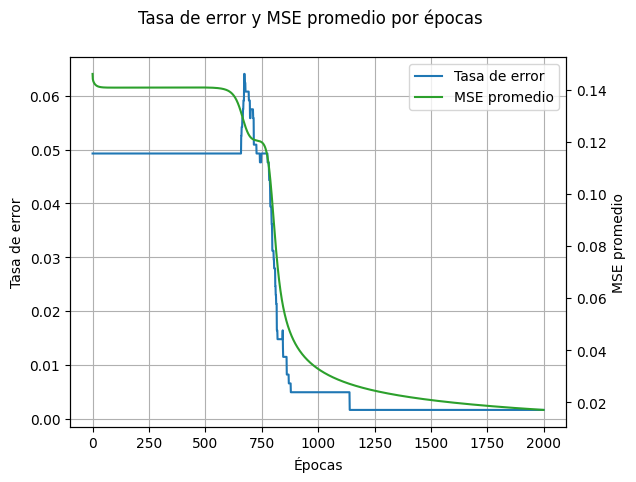

In [21]:
# Gráfica de la tasa de error por época junto con el MSE promedio por época
epochs = errorRatePerEpoch.shape[0]
xx_ = range(epochs)

fig1, fig1_ax = plt.subplots()
fig1.suptitle("Tasa de error y MSE promedio por épocas")
fig1_ax.set_xlabel('Épocas')
fig1_ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Solo ticks en enteros
fig1_ax.grid()
fig1_ax.set_ylabel('Tasa de error')

fig1_plot1 = fig1_ax.plot(xx_, errorRatePerEpoch, label='Tasa de error')

fig1_ax2 = fig1_ax.twinx()
fig1_plot2 = fig1_ax2.plot(xx_, MMSEPerEpoch, label='MSE promedio', color='C2')
fig1_ax2.set_ylabel('MSE promedio')

# added these three lines
lns = fig1_plot1+fig1_plot2
labs = [l.get_label() for l in lns]
fig1_ax.legend(lns, labs, loc=0)

plt.show()

### Test

In [22]:
# Generar el vector de entradas para test
XTest = ds[testPartitionsIdx[0,:], :-1]
# Generar el vector de salida deseada para test
YdTest = ds[testPartitionsIdx[0,:], -1]

errorsAccum_ = 0     # Acumulador de errores
for pattern, yd in zip(XTest, YdTest):
    # Calcular la salida
    z_ = MultiLayerPerceptron_forward(mlp, pattern)
    
    # Codificación de la salida
    y_ = -1 if (z_[-1] < 0) else 1
    
    # Comparación con la salida deseada y acumulación de errores
    errorsAccum_ += int(y_ != yd)

print(f'Tasa de error en prueba {errorsAccum_ / XTest.shape[0]}')

Tasa de error en prueba 0.016129032258064516


### Plot

In [23]:
# Evaluar todos los patrones
allPatternsEvaluated = np.array([MultiLayerPerceptron_forward(mlp, pattern)[-1] for pattern in ds[:,:-1]]).flatten()
ones_ = allPatternsEvaluated >= 0
allPatternsEvaluated[ones_] = 1
allPatternsEvaluated[~ones_] = -1

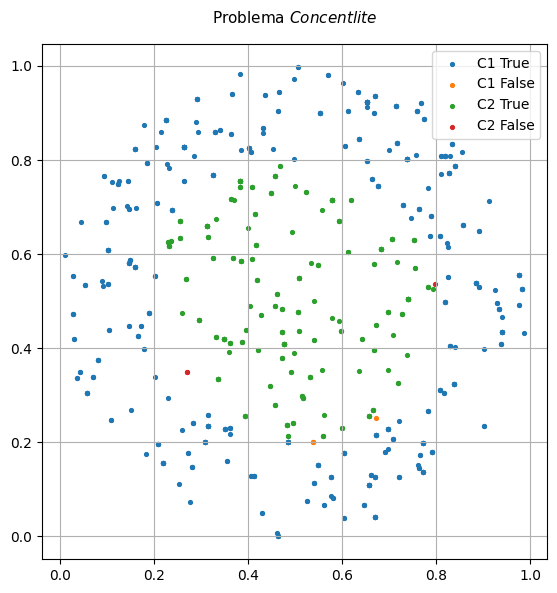

In [24]:
fig1, fig1_ax = plt.subplots(figsize=(7, 6), tight_layout=True)
fig1.suptitle('Problema $Concentlite$',  fontsize=11)
fig1_ax.set_aspect('equal')
fig1_ax.grid()


# Patrones
x_x = ds[:,0]
x_y = ds[:,1]
c = np.zeros((len(allPatternsEvaluated)), 'int')

# [1] = clase 1 - bien identificados
c1_idx = (allPatternsEvaluated == 1) & (ds[:,-1] == 1)
fig1_ax.scatter(x_x[c1_idx], x_y[c1_idx], s=30, marker='.', label='C1 True')
# [2] = clase 1 - mal identificados
c2_idx = (allPatternsEvaluated == -1) & (ds[:,-1] == 1)
fig1_ax.scatter(x_x[c2_idx], x_y[c2_idx], s=30, marker='.', label='C1 False')
# [3] = clase 2 - bien identificados
c3_idx = (allPatternsEvaluated == -1) & (ds[:,-1] == -1)
fig1_ax.scatter(x_x[c3_idx], x_y[c3_idx], s=30, marker='.', label='C2 True')
# [4] = clase 2 - mal identificados
c4_idx = (allPatternsEvaluated == 1) & (ds[:,-1] == -1)
fig1_ax.scatter(x_x[c4_idx], x_y[c4_idx], s=30, marker='.', label='C2 False')

fig1_ax.legend()

plt.show()

### Término de momento

Verifique experimentalmente la influencia de la incorporación del término de momento en la ecuación de adaptación de los pesos. Para esto, modifique su implementación para incluir el término de momento y compare la velocidad de convergencia del algoritmo.

Término de momento: $\alpha \Delta w_{n-1}$

Ecuación de actualización de pesos: 
$$\Delta w^{II}_{n} = \mu \delta^{II} Y^{I} + \alpha \Delta w^{II}_{n-1}$$
$$ w^{II}_{n} = w_{n-1}^{II} + \Delta w_{n}^{II}$$

### Prueba con perceptrón simple

Convierta los patrones de $concentlite.csv$ a una sola dimensión, obtenida como la distancia euclídea de cada patrón a la media total. Entrene un perceptrónn simple con estos nuevos datos unidimensionales y compare los resultados obtenidos en los puntos anteriores.